In [1]:
# Connection du notebook au google drive perso

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installation du keras tuner dans l'environnement du notebook car pas installé par défaut

!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.8 MB/s eta 0:00:00


In [3]:
# Import des packages / librairies / fonctions nécessaires

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
import zipfile
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import keras_tuner
from keras_tuner.tuners import RandomSearch, Hyperband
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [4]:
# Dézippage des sets d'images (stockés sur google drive) dans l'environnement du notebook

# Dézippage train set
!unzip -q '/content/drive/MyDrive/Perso/projet_radio/TrainSet.zip'

# Dézippage test set
!unzip -q '/content/drive/MyDrive/Perso/projet_radio/TestSet.zip'

In [5]:
# Affichage du lien du répertoire du set d'entrainement
train_set_dir = pathlib.Path("/content/Train/").with_suffix('')

# Vérification nombre d'images dans le set d'entrainement
print ("Répertoire train set : ", train_set_dir)
train_set_image_count = len(list(train_set_dir.glob('*/*.png')))
print("Nombre images train set ", train_set_image_count)

print ("\n")

# Affichage du lien du répertoire du set de test
test_set_dir = pathlib.Path("/content/Test/").with_suffix('')

# Vérification nombre d'images dans le set de test
print ("Répertoire test set : ", test_set_dir)
test_set_image_count = len(list(test_set_dir.glob('*/*.png')))
print("Nombre images test set ", test_set_image_count)

Répertoire train set :  /content/Train
Nombre images train set  4304


Répertoire test set :  /content/Test
Nombre images test set  1076


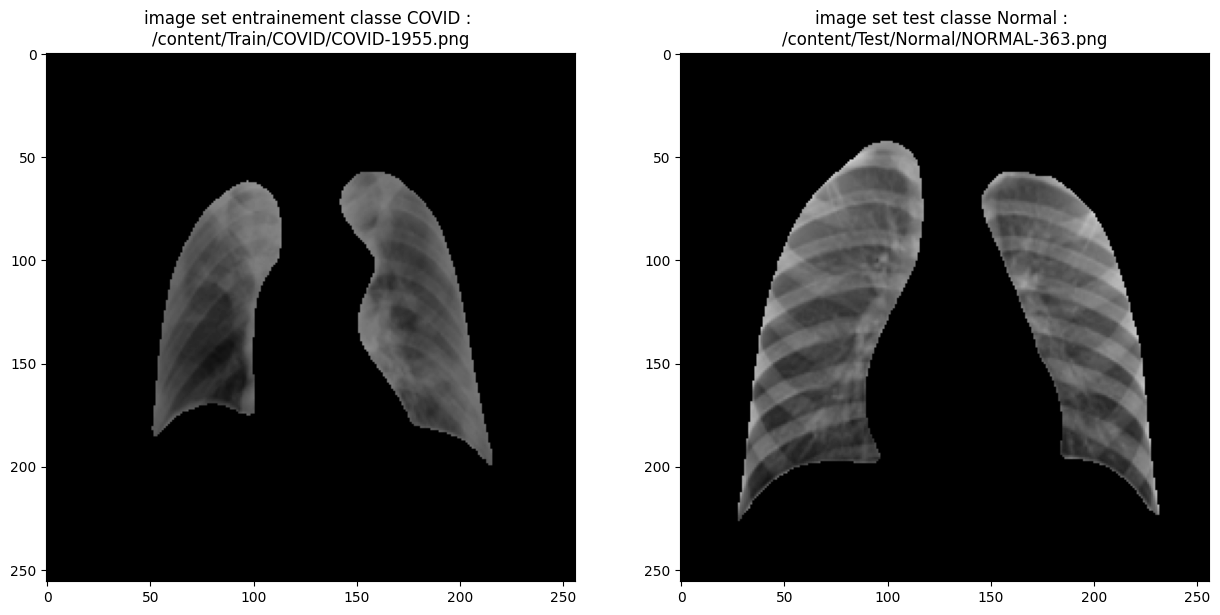

In [6]:
# Vérification basique ouverture + affichage d'une image des sets d'images

fig, axs = plt.subplots(1,2, figsize = (15,15))

# Image du set d'entrainement
COVID = list(train_set_dir.glob('COVID/*'))
img_train_set = cv2.imread(str(COVID[0]), cv2.IMREAD_GRAYSCALE)
axs[0].imshow(img_train_set, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("image set entrainement classe COVID : " + "\n" + str(COVID[0]))

# Image du set de test
Normal = list(test_set_dir.glob('Normal/*'))
img_test_set = cv2.imread(str(Normal[0]), cv2.IMREAD_GRAYSCALE)
axs[1].imshow(img_test_set, cmap = 'gray', vmin = 0, vmax = 255)
axs[1].set_title("image set test classe Normal : " + "\n" + str(Normal[0]))

plt.show()


In [7]:
# Définition de paramètres globaux

batch_size = 32  # valeur "standard" pour des dataset de relatives petites tailles comme sur ce projet
img_height = 256
img_width = 256
validation_split_ratio= 0.2
num_epochs = 15
keras_tuner_logs_dir = "keras_tuner/logs"

In [8]:
# Création des sets d'entrainement et de validation au format keras

# Création du set d'entrainement
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=validation_split_ratio,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb', # RGB nécessaire en transfer learning
  batch_size=batch_size,
)

# Création du set de validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=validation_split_ratio,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size,
 )

# Création du set de test
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_set_dir,
  image_size=(img_height, img_width),
  color_mode = "rgb",
  shuffle = False
  )


Found 4304 files belonging to 4 classes.
Using 3444 files for training.
Found 4304 files belonging to 4 classes.
Using 860 files for validation.
Found 1076 files belonging to 4 classes.


In [9]:
# Vérification du découpage en classes de keras

# Set d'entrainement
train_class_names = train_ds.class_names
print("Classes détectées par KERAS dans le set d'entrainement : ", train_class_names)

# Set de validation
val_class_names = val_ds.class_names
print("Classes détectées par KERAS dans le set de validation : ", val_class_names)

# Création d'une variable globale contenant le nombre de classes
num_classes = len(train_class_names)

Classes détectées par KERAS dans le set d'entrainement :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
Classes détectées par KERAS dans le set de validation :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [53]:

#from keras.applications.vgg19 import VGG19, preprocess_input
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.applications.xception import Xception, preprocess_input
#from keras.applications.resnet import ResNet50, ResNet101, preprocess_input
#from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, preprocess_input
#from keras.applications.mobilenet import MobileNet, preprocess_input
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications.densenet import DenseNet121, DenseNet201, preprocess_input
from keras.applications.efficientnet import EfficientNetB0, EfficientNetB7, preprocess_input

# comme on travaille avec un dataset keras contenant images + labels, il faut appliquer le
# pre-processing d'images spécifique au modèle uniquement sur la partie du dataset contenant les images
def preprocess(images, labels):
  return preprocess_input(images), labels

# application pré-processing d'images spécifique au modèle
train_ds_norm = train_ds.map(preprocess)
val_ds_norm = val_ds.map(preprocess)
test_ds_norm = test_ds.map(preprocess)

# 0 = : toutes les couches du modèle de base sont freezées
# >0 : nombre de couches à defreezer à la fin du modèle de base
fine_tune = 191

#base_model = VGG19(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = VGG16(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = Xception(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = ResNet101(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = ResNet101V2(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = MobileNet(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = DenseNet201(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
base_model = EfficientNetB0(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))
#base_model = EfficientNetB7(weights= 'imagenet', include_top=False, input_shape=(256, 256, 3))

#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name, layer.trainable)
#return 0

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, x)
#model._name = "xxx"

# Finetuning du modèle si paramétré
if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
        layer.trainable = False
else:
    base_model.trainable = False

#Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback_early_stopping = EarlyStopping(monitor='val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True,
    start_from_epoch = 3)

#Entraînement du modèle
history = model.fit(train_ds_norm,
                    validation_data=val_ds_norm,
                    epochs=10,
                    callbacks = [callback_early_stopping])

# Calcul d'accuracy sur le set de test
test_data = np.concatenate([x for x, y in test_ds_norm], axis=0)
test_label = np.concatenate([y for x, y in test_ds_norm], axis=0)
test_pred = model.predict(test_data)
test_pred_class = test_pred.argmax(axis = 1)
print(classification_report(test_label, test_pred_class))



Epoch 1/10
108/108 [==============================] - 40s 86ms/step - loss: 0.6969 - accuracy: 0.7204 - val_loss: 0.6653 - val_accuracy: 0.7384
Epoch 2/10
108/108 [==============================] - 8s 70ms/step - loss: 0.4760 - accuracy: 0.8290 - val_loss: 1.2551 - val_accuracy: 0.7035
Epoch 3/10
108/108 [==============================] - 8s 69ms/step - loss: 0.3530 - accuracy: 0.8740 - val_loss: 0.5906 - val_accuracy: 0.8523
Epoch 4/10
108/108 [==============================] - 8s 71ms/step - loss: 0.2920 - accuracy: 0.8975 - val_loss: 1.0535 - val_accuracy: 0.8012
Epoch 5/10
108/108 [==============================] - 8s 70ms/step - loss: 0.2548 - accuracy: 0.9085 - val_loss: 0.7494 - val_accuracy: 0.7709
Epoch 6/10
108/108 [==============================] - 8s 70ms/step - loss: 0.1924 - accuracy: 0.9338 - val_loss: 0.5826 - val_accuracy: 0.8628
Epoch 7/10
108/108 [==============================] - 8s 69ms/step - loss: 0.1709 - accuracy: 0.9396 - val_loss: 1.0401 - val_accuracy: 0.761

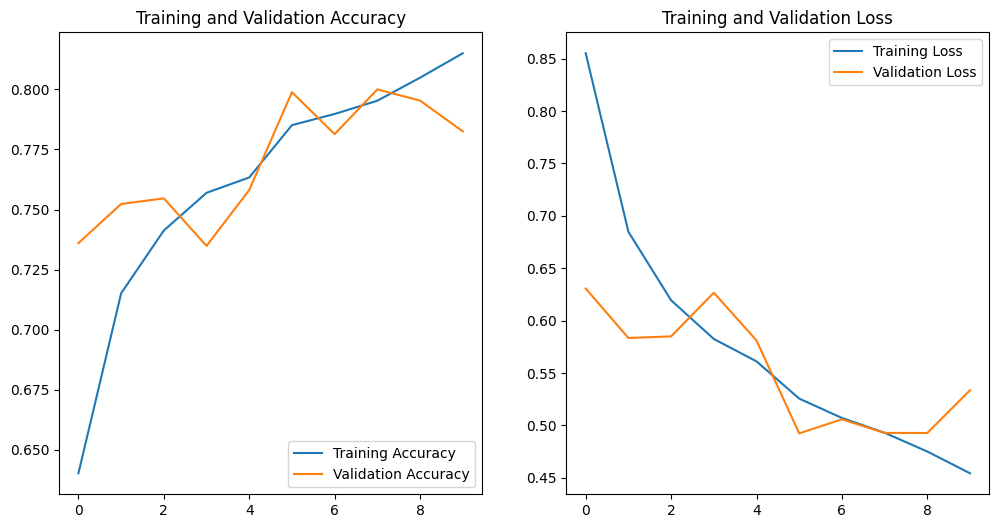

In [16]:
#Visualize training results
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()